<h1> Don't Overfit </h1>
<br>
<br>
This report is the process that was untaken to create the model that was entered into the Kaggle competition,"Don't Overfit".The premise of the competition is stated below : 
<br>
<br>
<blockquote>"we have 20,000 rows of continuous variables, and a mere handful of training samples. Once again, we challenge you not to overfit. Do your best, model without overfitting, and add, perhaps, to your own legend."</blockquote>
<br>
<br>
The basic structure of this report will consist of :
<ul>
    <li> Exploratory Data Analysis</li>
    <li> Exploring the Features Correlation</li>
    <li> Creating a scoring function </li>
    <li> Basic Modelling </li>
    <li> Experimenting with the model - Feature selection </li>
</ul>

<h2> Exploratory Data Analysis</h2>

From an initial look, we can see the following information :
<ul> 
    <li> Dataset contains Interval Data.</li>
    <li> It has 300 features and only 250 records </li>
    <li> There is an imbalance in the classification of 16/25 </li>
    <li> There is no missing Data</li>
</ul>

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
import numpy as np

In [138]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

The information below shows example records of the dataframe, a brief description of the dataframe , the balance of the binary classifications and any missing data.

In [139]:
print("Dataframe")
print(train.head(2))
print("----------------------------------------------------")
print("Info")
print(train.info())
print(test.info())
print("----------------------------------------------------")
print("Label Count")
print(train["target"].value_counts())
print("----------------------------------------------------")
print("Missing Data")
print(train.isnull().any().any())

Dataframe
   id  target      0      1      2      3      4      5      6      7  ...    \
0   0     1.0 -0.098  2.165  0.681 -0.614  1.309 -0.455 -0.236  0.276  ...     
1   1     0.0  1.081 -0.973 -0.383  0.326 -0.428  0.317  1.172  0.352  ...     

     290    291    292    293    294    295    296    297    298    299  
0  0.867  1.347  0.504 -0.649  0.672 -2.097  1.051 -0.414  1.038 -1.065  
1 -0.165 -1.695 -1.257  1.359 -0.808 -1.624 -0.458 -1.099 -0.936  0.973  

[2 rows x 302 columns]
----------------------------------------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 589.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Columns: 301 entries, id to 299
dtypes: float64(300), int64(1)
memory usage: 45.4 MB
None
----------------------------------------------------
Label Count
1.0    160
0.0     90
Name: target, dtype: int64
--

In [140]:
train_details = train.describe()
test_details = test.describe()

The graph below shows the Std and mean of the dataframe. 

C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Mean for Testing/ Training set')

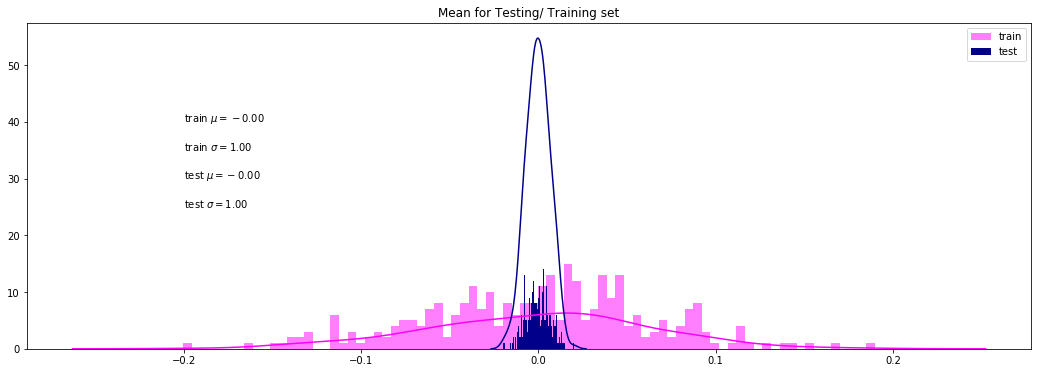

In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
new_feature1 = pd.DataFrame(scaler.fit_transform(train.iloc[:,2:]))
test_feature1 = pd.DataFrame(scaler.transform(test.iloc[:,1:]))
new_feature = new_feature1.describe()
test_feature = test_feature1.describe()



fig = plt.figure(figsize=(18,6))
g = gs.GridSpec(1,1,fig)
ax = fig.add_subplot(g[0,0])




ax.hist(train_details.loc["mean","0":], alpha = 0.5,color="magenta", bins=80, label='train')
ax.hist(test_details.loc["mean","0":],color="darkblue",bins=80, label='test')
ax.text(-0.2, 40, r"train $\mu={0:3.2f}$".format(train_details.loc["mean","0":].mean()))
ax.text(-0.2, 35, r"train $\sigma={0:3.2f}$".format(train_details.loc["std","0":].mean()))
ax.text(-0.2, 30, r"test $\mu={0:3.2f}$".format(test_details.loc["mean","0":].mean()))
ax.text(-0.2, 25, r"test $\sigma={0:3.2f}$".format(test_details.loc["std","0":].mean()))

ax.legend(loc=0)
sns.kdeplot(train_details.loc["mean","0":],color="magenta" , ax=ax, legend =False)
sns.kdeplot(test_details.loc["mean","0":],color="darkblue" , ax=ax, legend =False)
ax.set_title("Mean for Testing/ Training set")


You can see that there has been some distortion to the train data, so even though it has the same mean and std as the train dataset, the scale is not the same. To fix this issue,the sklearn standard scaler was used to put both datasets on the same scale. As the data has a normal distributed within each feature, the scale will  distribute the data around 0, with a standard deviation of 1. 
<br> 
<br>
To do this, the mean and standard deviation are calculated for the feature and then the feature is scaled based on: x(i)–mean(x) / stdev(x)

After looking at the mean and std, a graph was made to examine the coefficient and correlation for each feature. 

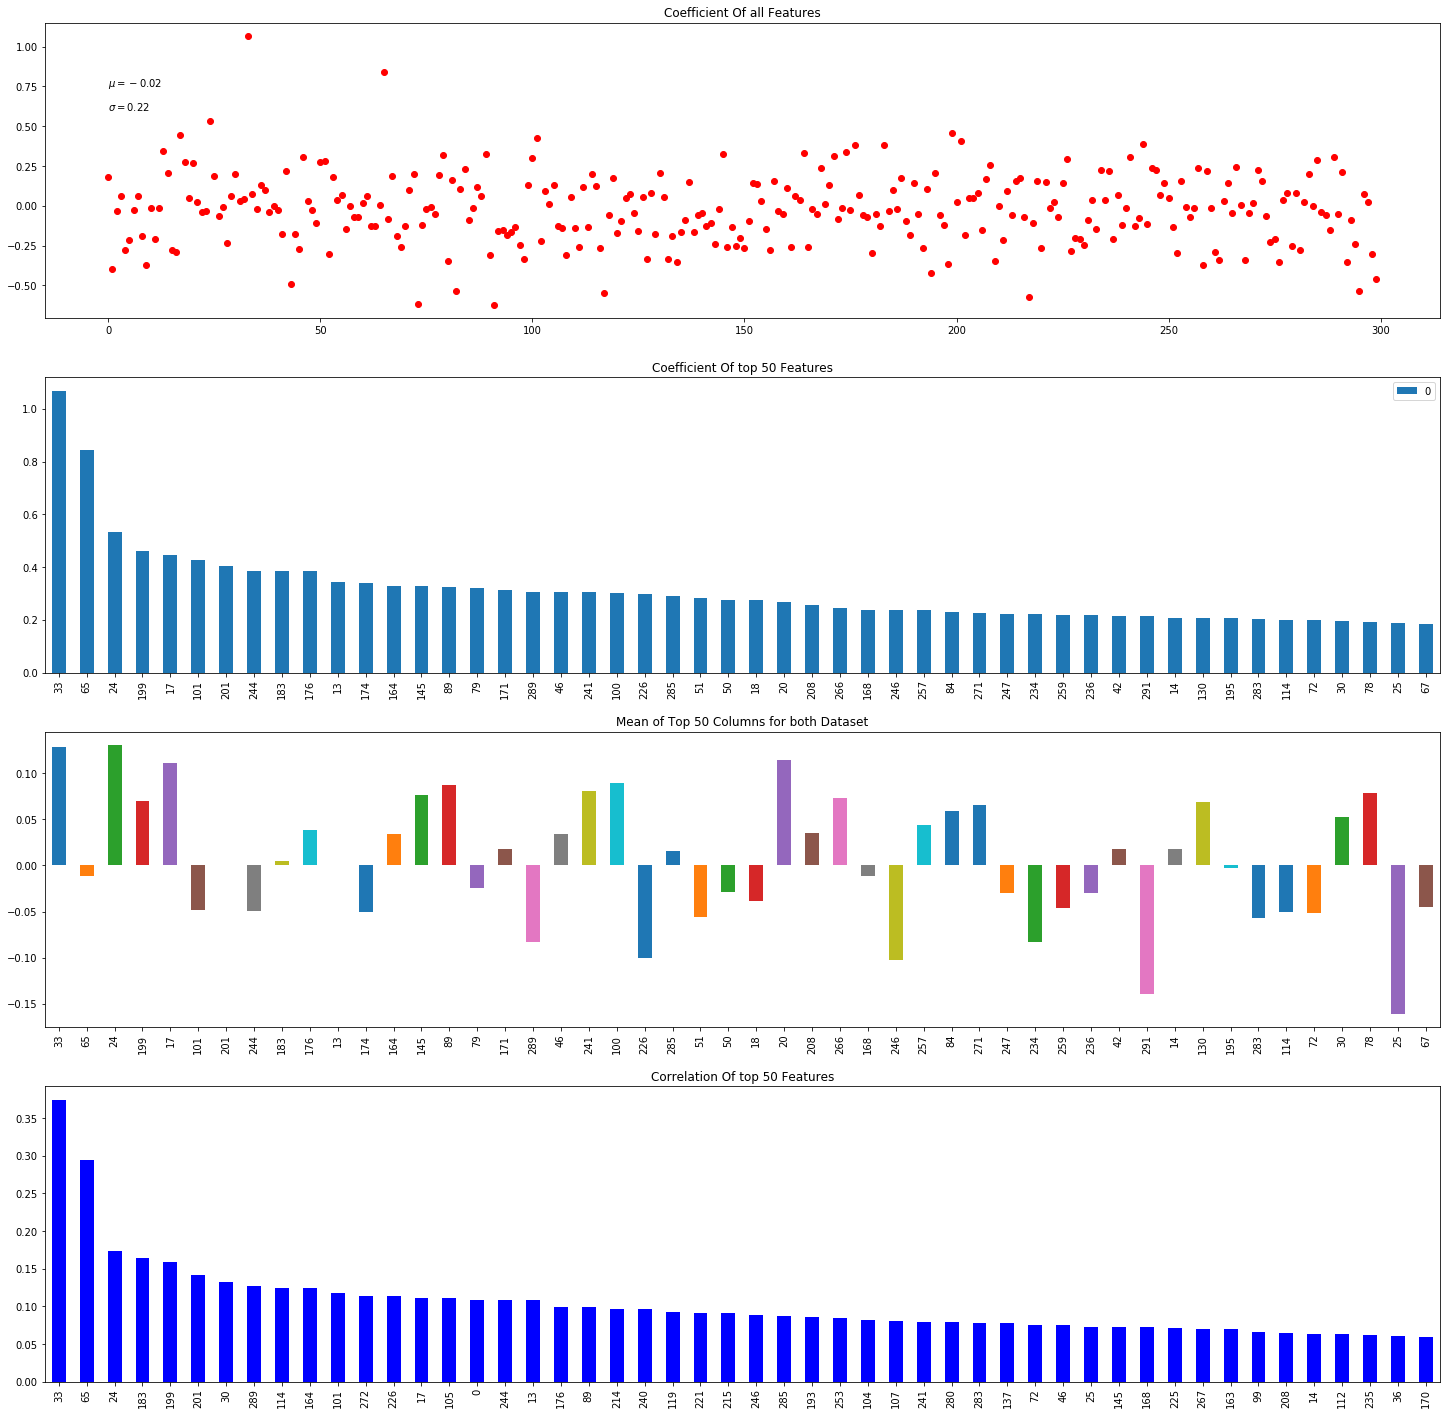

In [142]:
from sklearn.linear_model import LogisticRegression

data =pd.concat([ test_feature1 , new_feature1.iloc[:,:]])

lr = LogisticRegression(solver='liblinear')

lr.fit(new_feature1.iloc[:,:], train.iloc[:,1])
coeff = pd.DataFrame(lr.coef_)
mean = coeff.T.mean()
std = coeff.T.std()
coeff_50 = coeff.T.sort_values(by=0,ascending = False).iloc[:50,:]
col = coeff_50.index 
data = data[col]
data = data.describe()

df_corr = new_feature1.iloc[:,:].apply(lambda x: x.corr(train.iloc[:,1]))
df_corr = df_corr.reset_index().sort_values(by=0,ascending = False).iloc[:50,:]





fig = plt.figure(figsize=(25,25))
g = gs.GridSpec(4,1,fig)
ax = fig.add_subplot(g[0,0])
ax2 = fig.add_subplot(g[1,0])
ax3 = fig.add_subplot(g[2,0])
ax4 = fig.add_subplot(g[3,0])

ax.set_title("Coefficient Of all Features")
ax.plot(coeff.T,'ro' )
ax.text(0, 0.75, r"$\mu={0:3.2f}$".format(mean[0]))
ax.text(0, 0.60, r"$\sigma={0:3.2f}$".format(std[0]))

ax2.set_title("Coefficient Of top 50 Features")
coeff_50.plot.bar(ax=ax2)

ax3.set_title("Mean of Top 50 Columns for both Dataset")
data.loc["mean",:].plot.bar(ax=ax3)

ax4.set_title("Correlation Of top 50 Features")
df_corr.iloc[:,1].plot.bar(ax=ax4,color ="Blue")



The report will now examine the train dataset vs the test dataset in greater depth.

C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


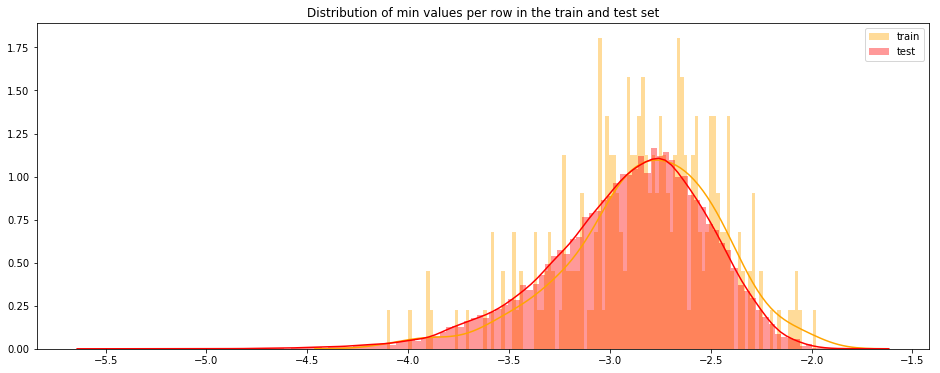

In [143]:
plt.figure(figsize=(16,6))

plt.title("Distribution of min values per row in the train and test set")
sns.distplot(new_feature1.min(axis=1),color="orange", kde=True,bins=120, label='train')
sns.distplot(test_feature1.min(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()



The min KDE for the train dataset is slighly skewed right when compared to the test dataset.

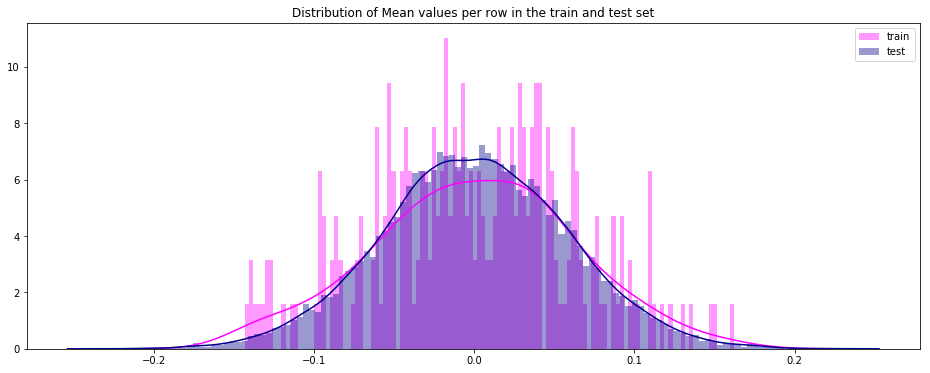

In [144]:
plt.figure(figsize=(16,6))

plt.title("Distribution of Mean values per row in the train and test set")
sns.distplot(new_feature1.mean(axis=1),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_feature1.mean(axis=1),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

The mean's KDE for train and test dataset is slightly different with the test dataset having a taller distribution.

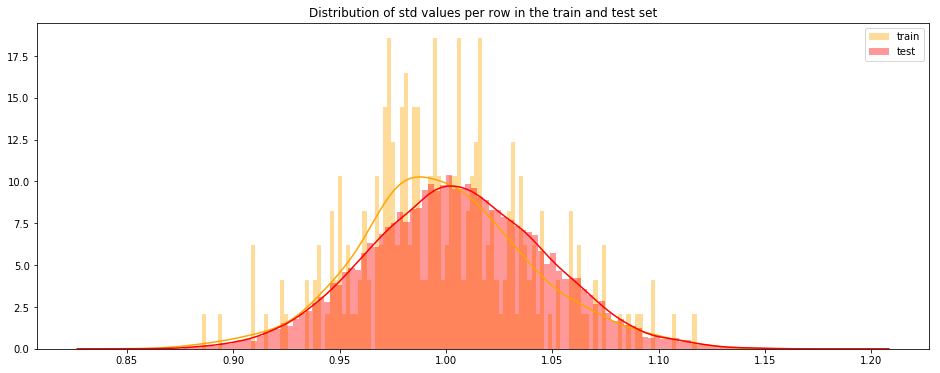

In [145]:
plt.figure(figsize=(16,6))

plt.title("Distribution of std values per row in the train and test set")
sns.distplot(new_feature1.std(axis=1),color="orange", kde=True,bins=120, label='train')
sns.distplot(test_feature1.std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Again, there are differences in the std KDE between the train and test dataset with the train test being skewed to the right. One factor that could explain this difference is the bias in the dataset. As there are many more positive targets than negatives ones, this could explain the differences in the train/ test dataset if the test dataset had a 50-50% split. 

C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


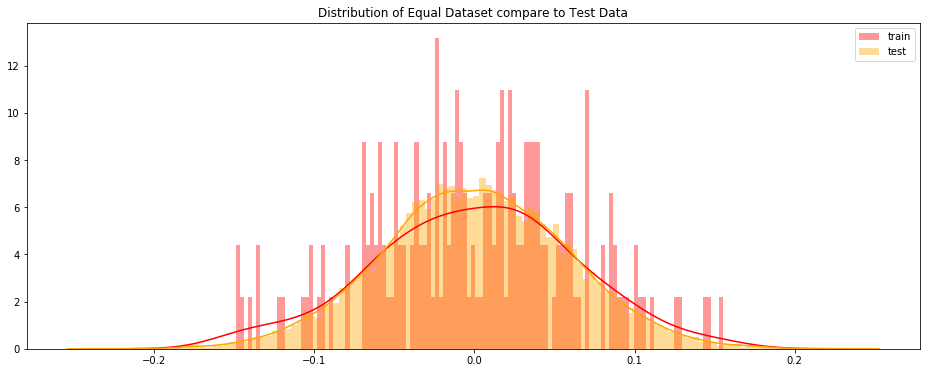

In [146]:
features_90 = train[train["target"] == 1]
features_902 = train[train["target"] == 0]
features_90 = features_90.iloc[:90,:]
features_90_final = pd.concat([features_90, features_902])
features_90_final = pd.DataFrame(scaler.fit_transform(features_90_final.iloc[:,2:]))


plt.figure(figsize=(16,6))

plt.title("Distribution of Equal Dataset compare to Test Data")
sns.distplot(features_90_final.mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_feature1.mean(axis=1),color="orange", kde=True,bins=120, label='test')

plt.legend()
plt.show()



When the data that had a 50-50% split was compared to the test dataset, it showed a difference between the two dataset. 
<br>
<br> 
This shows the biggest problem that we face. If we reduce the variance in our training dataset then the model will overfit, as the training and test data has a big enough differences to predict high acc and roc scores on the training data but not on the test dataset.  

<h1>Creating the Cross validation Scoring Function</h1>

In [147]:
def scores(X ,y, model):
    score = []
    score2 = []
    results = cross_val_score(model, X, y, cv = 3, scoring = 'roc_auc')
    results2 = cross_val_score(model, X, y, cv = 3, scoring = 'accuracy')
    score.append(results)
    score2.append(results2)
    score_df = pd.DataFrame(score).T
    score_df.loc['mean'] = score_df.mean()
    score_df.loc['std'] = score_df.std()
    score_df= score_df.rename(columns={0:'roc_auc'})
    print(score_df.iloc[-2:,:])
    score_df2 = pd.DataFrame(score2).T
    score_df2.loc['mean'] = score_df2.mean()
    score_df2.loc['std'] = score_df2.std()
    score_df2= score_df2.rename(columns={0:'acc'})
    print(score_df2.iloc[-2:,:])

<h1> Optimising the Classifiers </h1>
Due to the nature of the compeition, a binary classification competition, a Logestic Model was used to start the alogorithm exploration. A GridSearch was then performed on the Logistic Regression model to optimise the classifier.  

In [73]:
from sklearn.model_selection import GridSearchCV ,cross_val_score
clf = LogisticRegression(max_iter=4000)


param_grid = [
  {'class_weight' : ['balanced', None],'penalty': ['l1'], 'solver': ['liblinear', 'saga'],'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
  {'class_weight' : ['balanced', None],'penalty': ['l2'], 'solver': ['newton-cg','lbfgs'],'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
 {'class_weight' : ['balanced', None],'penalty': ['l2','l1'], 'solver': ['saga'],'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
 ]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='roc_auc')
grid_search.fit(new_feature1, train.iloc[:,1])
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8020833333333335
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


The best parameters from the GridSearch were then used to make the first submission. 

<h1> Feature Selection </h1> 

There are a number of feature selection methods that could be used to select the features for our classifier. The Feature Selection methods that I used was : Recursive Feature Elimination.
<br>
<br>
This process obtains the importance of each feature and recursively drops the feature with the least coefficient or importance until it finds the selection with the best number of features.
<br>
<br>
PCA was not used as the correlation between variables was not deemed as strong or even moderate. This lacking of strength between correlations can be seen in the heatmap graph below. 


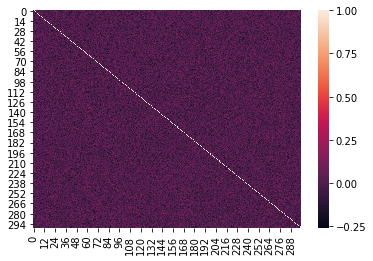

In [75]:
new_features_corr = new_feature1.corr()
sns.heatmap(new_features_corr)

In [ ]:
model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear')
from sklearn.feature_selection import RFE

rfr_grid =  [5,10,15,25, 50, 75, 100, 125, 150, 175, 200 ,225,250,275,300]

for feature_num in rfr_grid :
    selector = RFE(model, feature_num, step=1)
    selector = selector.fit(new_feature1, train.iloc[:,1])
    new_features =  selector.transform(new_feature1)
    print("Number of Features {}".format(feature_num))
    scores(new_feature1,train.iloc[:,1],selector)

As we can see that the ROC score ranges from 0.703 to 0.808. However, we need to consider the problem of overfitting to the training model. Based on the fact that : 
<ul>
    <li> The coefficient has a mean of -0.02 and std of 0.22</li>
    <li> The differences between the train and test dataset will make overfitting likely</li>
</ul>
a decicision was made to make the model simpler so that we try and reduce the bias and hopefully stop overfitting to our train dataset. These means we must reduce the number of features and then further tune the model so that we can make sure that we get the best bias-variance trade off that we can.

25 Variables were selected for the model. The variables the were selected can be seen below

In [76]:
selector = RFE(model,25, step=1)
selector = selector.fit(new_feature1, train.iloc[:,1])
new_features =  selector.transform(new_feature1)
bool_mask = pd.Series(selector.support_,name='bools') 
scores(new_feature1,train.iloc[:,1],selector)
col = []
for num, i  in enumerate(bool_mask):
    if i ==True :
        col.append(num)

rfe_feature = new_feature1[col]
rfe_test = test_feature1[col]
print("The columns that were used were {}".format(col))

       roc_auc
mean  0.807019
std   0.025237
           acc
mean  0.712039
std   0.008416
The columns that were used were [16, 33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 117, 127, 133, 134, 165, 189, 194, 199, 217, 226, 258, 295, 298]


An examination of the test and train  once again occured to see the difference between the two dataset. 

C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


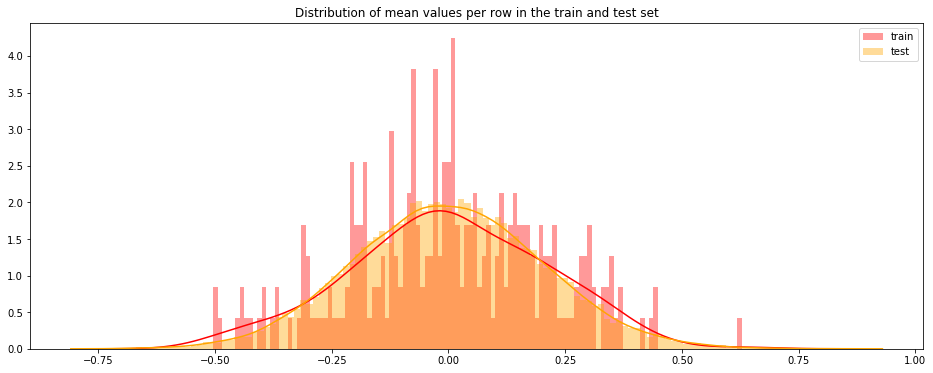

In [77]:
plt.figure(figsize=(16,6))

plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(rfe_feature.mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(rfe_test.mean(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

With the reduced features we can see that the width of the distributions are similar, which can help us tune our model and so increase our ROC score on both the training and testing dataset. The first method was to add new features to the data. A quick evaluation on the postive and negative targets took place.

In [78]:
rfe_feature["sum"] = rfe_feature.sum(axis=1)
rfe_feature["min"] = rfe_feature.min(axis=1)
rfe_feature["max"] = rfe_feature.max(axis=1)
rfe_feature["mean"] = rfe_feature.mean(axis=1)
rfe_feature["std"] = rfe_feature.std(axis=1)
rfe_feature["skew"] = rfe_feature.skew(axis=1)
rfe_feature["var"] = rfe_feature["std"]**2

rfe_feature["target"] = train.iloc[:,1]



rfe_test["sum"] = rfe_test.sum(axis=1)
rfe_test["min"] = rfe_test.min(axis=1)
rfe_test["max"] = rfe_test.max(axis=1)
rfe_test["mean"] = rfe_test.mean(axis=1)
rfe_test["std"] = rfe_test.std(axis=1)
rfe_test["skew"] = rfe_test.skew(axis=1)
rfe_test["var"] = rfe_test["std"]**2


rfe_feature_true = rfe_feature[rfe_feature["target"] == 1]
rfe_feature_false = rfe_feature[rfe_feature["target"] == 0]



C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\NJGaj\Anaconda3\envs\map\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

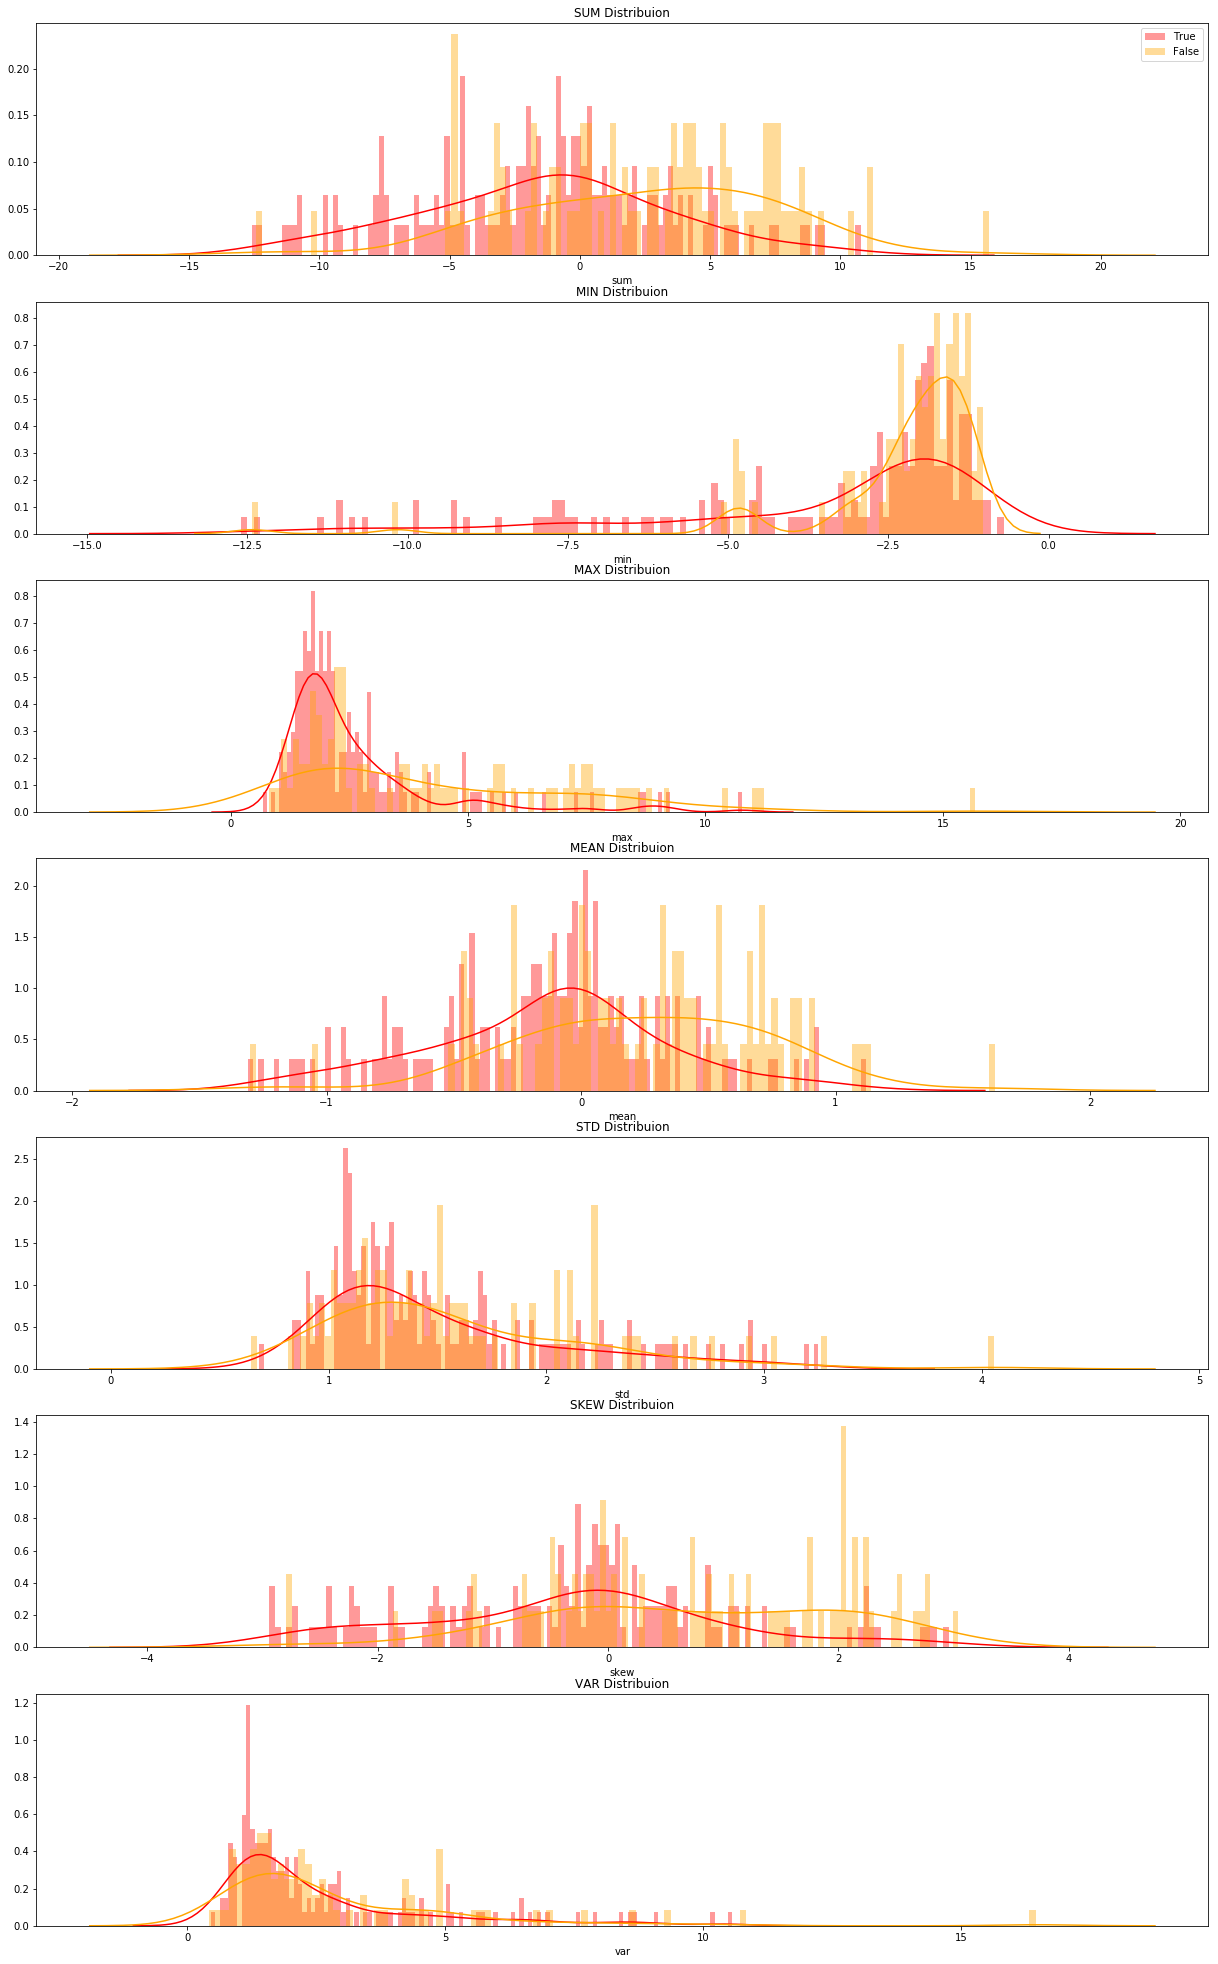

In [79]:
fig = plt.figure(figsize=(21,35))
g = gs.GridSpec(7,1,fig)
ax = fig.add_subplot(g[0,0])
ax1 = fig.add_subplot(g[1,0])
ax2 = fig.add_subplot(g[2,0])
ax3 = fig.add_subplot(g[3,0])
ax4= fig.add_subplot(g[4,0])
ax5 = fig.add_subplot(g[5,0])
ax6 = fig.add_subplot(g[6,0])


ax.set_title("SUM Distribuion")
sns.distplot(rfe_feature_true["sum"],color="red", kde=True,bins=120, label='True' ,ax=ax)
sns.distplot(rfe_feature_false["sum"],color="orange", kde=True,bins=120, label='False',ax=ax)

ax1.set_title("MIN Distribuion")
sns.distplot(rfe_feature_true["min"],color="red", kde=True,bins=120, label='True' ,ax=ax1)
sns.distplot(rfe_feature_false["min"],color="orange", kde=True,bins=120, label='False',ax=ax1)

ax2.set_title("MAX Distribuion")
sns.distplot(rfe_feature_true["max"],color="red", kde=True,bins=120, label='True' ,ax=ax2)
sns.distplot(rfe_feature_false["max"],color="orange", kde=True,bins=120, label='False',ax=ax2)

ax3.set_title("MEAN Distribuion")
sns.distplot(rfe_feature_true["mean"],color="red", kde=True,bins=120, label='True' ,ax=ax3)
sns.distplot(rfe_feature_false["mean"],color="orange", kde=True,bins=120, label='False',ax=ax3)

ax4.set_title("STD Distribuion")
sns.distplot(rfe_feature_true["std"],color="red", kde=True,bins=120, label='True' ,ax=ax4)
sns.distplot(rfe_feature_false["std"],color="orange", kde=True,bins=120, label='False',ax=ax4)

ax5.set_title("SKEW Distribuion")
sns.distplot(rfe_feature_true["skew"],color="red", kde=True,bins=120, label='True' ,ax=ax5)
sns.distplot(rfe_feature_false["skew"],color="orange", kde=True,bins=120, label='False',ax=ax5)

ax6.set_title("VAR Distribuion")
sns.distplot(rfe_feature_true["var"],color="red", kde=True,bins=120, label='True' ,ax=ax6)
sns.distplot(rfe_feature_false["var"],color="orange", kde=True,bins=120, label='False',ax=ax6)

ax.legend(loc="best")


As you can see that each of new the values show differences between the target values. Therefore, I will recursively eliminate the features see how they improve the ROC score.


In [80]:
rfe_feature = rfe_feature.drop(["target"],axis=1)

In [104]:
model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear',tol=0.02,verbose=0)
rfr_grid =  [23,24,25,26,27,28,29,30,31,32]

for feature_num in rfr_grid :
    selector = RFE(model, feature_num, step=1)
    selector = selector.fit(rfe_feature, train.iloc[:,1])
    new_features =  selector.transform(rfe_feature)
    print("Number of Features {}".format(feature_num))
    scores(new_features,train.iloc[:,1],selector)

Number of Features 23
       roc_auc
mean  0.924757
std   0.015887
           acc
mean  0.828122
std   0.023706
Number of Features 24
       roc_auc
mean  0.924757
std   0.016386
           acc
mean  0.828122
std   0.023706
Number of Features 25
       roc_auc
mean  0.924128
std   0.015755
           acc
mean  0.828122
std   0.023706
Number of Features 26
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 27
       roc_auc
mean  0.924757
std   0.015887
           acc
mean  0.828122
std   0.023706
Number of Features 28
       roc_auc
mean  0.924757
std   0.016386
           acc
mean  0.828122
std   0.023706
Number of Features 29
       roc_auc
mean  0.925177
std   0.016318
           acc
mean  0.828122
std   0.023706
Number of Features 30
       roc_auc
mean  0.924548
std   0.016173
           acc
mean  0.828122
std   0.023706
Number of Features 31
       roc_auc
mean  0.925173
std   0.016171
           acc
mean  0.828122
std   0

In [105]:
selector = RFE(model,23, step=1)
selector = selector.fit(rfe_feature, train.iloc[:,1])
new_features =  selector.transform(rfe_feature)
new_test = selector.transform(rfe_test)

bool_mask = pd.Series(selector.support_,name='bools') 
scores(new_features,train.iloc[:,1],selector)
old_cols = [16, 33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 117, 127, 133, 134, 165, 189, 194, 199, 217, 226, 258, 295, 298,"sum","min","max","mean","std","skew","var"]
col = []
for num, i  in enumerate(bool_mask):
 
    if i ==True :
        col.append(old_cols[num])
        
        


print("The columns that were used were {}".format(col))

       roc_auc
mean  0.924757
std   0.015887
           acc
mean  0.828122
std   0.023706
The columns that were used were [33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 199, 217, 226, 258, 295, 298, 'sum', 'min', 'max', 'mean', 'std', 'skew']


In [106]:
model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear')
model = model.fit(new_features, train.iloc[:,1])


In [107]:
prediction5 = model.predict_proba(new_test)

test["target"]= prediction5[:,1]
submission = test[["id","target"]]
submission.to_csv("submission14.csv",index=False)

This resulted in huge overfitting. From the initial graphs ,we can see that the std ditribution is more of a Gemma shape than a Gaussian one. This means that I will delete both the std and variance feature.

In [108]:
rfe_feature2  =rfe_feature.drop(["std","var"], axis = 1)
rfe_test2  =rfe_test.drop(["std","var"], axis = 1)

In [109]:

model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear')
rfr_grid =  [23,24,25,26,27,28,29,30,]

for feature_num in rfr_grid :
    selector = RFE(model, feature_num, step=1)
    selector = selector.fit(rfe_feature2, train.iloc[:,1])
    new_features =  selector.transform(rfe_feature2)
    print("Number of Features {}".format(feature_num))
    scores(new_features,train.iloc[:,1],selector)

Number of Features 23
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 24
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 25
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 26
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 27
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 28
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 29
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
Number of Features 30
       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706


In [112]:
selector = RFE(model,23, step=1)
selector = selector.fit(rfe_feature2, train.iloc[:,1])
new_features =  selector.transform(rfe_feature2)
new_test = selector.transform(rfe_test2)
bool_mask = pd.Series(selector.support_,name='bools') 
scores(new_features,train.iloc[:,1],selector)
old_cols = [16, 33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 117, 127, 133, 134, 165, 189, 194, 199, 217, 226, 258, 295, 298,"sum","min","max","mean","skew"]
col = []
for num, i  in enumerate(bool_mask):
    if i ==True :
        col.append(old_cols[num])

print("The columns that were used were {}".format(col))

       roc_auc
mean  0.924967
std   0.016101
           acc
mean  0.828122
std   0.023706
The columns that were used were [33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 194, 199, 217, 226, 258, 295, 298, 'sum', 'min', 'max', 'mean', 'skew']


In [113]:
model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear',tol=0.02,verbose=0)
model = model.fit(rfe_feature2, train.iloc[:,1])
prediction5 = model.predict_proba(rfe_test2)

test["target"]= prediction5[:,1]
submission = test[["id","target"]]
submission.to_csv("submission15.csv",index=False)

Again this resulted in high bias to the train dataset and therefore creating overfitting,so more of the features were dropped.

In [114]:
rfe_feature3  =rfe_feature.drop(["std","var","skew","min","max"], axis = 1)
rfe_test3  = rfe_test.drop(["std","var","skew","min","max"], axis = 1)

In [115]:
model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear',tol=0.02,verbose=0)
rfr_grid =  [23,24,25,26,27]

for feature_num in rfr_grid :
    selector = RFE(model, feature_num, step=1)
    selector = selector.fit(rfe_feature3, train.iloc[:,1])
    new_features =  selector.transform(rfe_feature3)
    print("Number of Features {}".format(feature_num))
    scores(new_features,train.iloc[:,1],selector)

Number of Features 23
       roc_auc
mean  0.928543
std   0.005393
           acc
mean  0.820090
std   0.018688
Number of Features 24
       roc_auc
mean  0.928546
std   0.005675
           acc
mean  0.816074
std   0.019698
Number of Features 25
       roc_auc
mean  0.928958
std   0.005649
           acc
mean  0.816074
std   0.019698
Number of Features 26
       roc_auc
mean  0.928329
std   0.004902
           acc
mean  0.820090
std   0.018688
Number of Features 27
       roc_auc
mean  0.928539
std   0.005659
           acc
mean  0.816074
std   0.019698


In [116]:
selector = RFE(model,26, step=1)
selector = selector.fit(rfe_feature3, train.iloc[:,1])
new_features =  selector.transform(rfe_feature3)
new_test = selector.transform(rfe_test3)
bool_mask = pd.Series(selector.support_,name='bools') 
scores(new_features,train.iloc[:,1],selector)
old_cols = [16, 33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 117, 127, 133, 134, 165, 189, 194, 199, 217, 226, 258, 295, 298,"sum","mean"]
col = []
for num, i  in enumerate(bool_mask):
    if i ==True :
        col.append(old_cols[num])

print("The columns that were used were {}".format(col))

       roc_auc
mean  0.928329
std   0.004902
           acc
mean  0.820090
std   0.018688
The columns that were used were [33, 43, 63, 65, 73, 80, 82, 90, 91, 101, 108, 117, 127, 133, 134, 165, 189, 194, 199, 217, 226, 258, 295, 298, 'sum', 'mean']


In [117]:
model = LogisticRegression(C=0.1,random_state=42,class_weight='balanced',penalty='l1',solver='liblinear')
model = model.fit(rfe_feature3, train.iloc[:,1])
prediction5 = model.predict_proba(rfe_test3)

test["target"]= prediction5[:,1]
submission = test[["id","target"]]
submission.to_csv("submission16.csv",index=False)

This showed a slight improvement however overfitting was still occuring. The next step was to try and combine a few models to reduce this overfitting.

<h1> Making an Emsemble </h1>

The two approaches that were used was the BaggingClassifier and  the VotingClassifier with the Votingclassifer offering better results on the test dataset. 

In [125]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import linear_model
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import ElasticNet

model_1= linear_model.SGDClassifier('log',eta0=1, max_iter=1000, tol=0.0001)
model_2 = GaussianNB()
model_3 = LogisticRegression( C = 0.1, class_weight ='balanced', penalty = 'l1', solver = 'liblinear')
model_4 =  ElasticNet(alpha = 0.085, l1_ratio = 0.5)
grid  = [1,3,6,9,12,15,18,20,22,24,28]


                          
for params in grid:
    blg = BaggingClassifier(base_estimator=model_3,n_estimators = params).fit(rfe_feature3,train.iloc[:,1])
    scores(rfe_feature3,train.iloc[:,1],blg)


blg = BaggingClassifier(base_estimator=model_3,n_estimators = 24).fit(rfe_feature3,train.iloc[:,1])
prediction5 = blg.predict_proba(rfe_test3)


test["target"]= prediction5[:,1]
submission = test[["id","target"]]
submission.to_csv("submission17.csv",index=False)

       roc_auc
mean  0.921791
std   0.014158
           acc
mean  0.828026
std   0.004665
       roc_auc
mean  0.923729
std   0.029371
           acc
mean  0.824154
std   0.027181
       roc_auc
mean  0.921217
std   0.008344
           acc
mean  0.828026
std   0.010888
       roc_auc
mean  0.930367
std   0.017357
           acc
mean  0.836059
std   0.010345
       roc_auc
mean  0.930173
std   0.012221
           acc
mean  0.816026
std   0.020205
       roc_auc
mean  0.924924
std   0.010260
           acc
mean  0.836059
std   0.014276
       roc_auc
mean  0.923309
std   0.008170
           acc
mean  0.824058
std   0.014227
       roc_auc
mean  0.921434
std   0.009641
           acc
mean  0.824010
std   0.024661
       roc_auc
mean  0.926007
std   0.013901
           acc
mean  0.828074
std   0.019743
       roc_auc
mean  0.927483
std   0.009699
           acc
mean  0.844043
std   0.009030
       roc_auc
mean  0.930193
std   0.006910
           acc
mean  0.836059
std   0.014276


In [136]:
eclf = VotingClassifier(estimators=[('NB', model_2), ('LR', model_3), ('LIN', model_1)],
                       voting='soft', weights=[1,2, 2])

eclf.fit(rfe_feature3,train.iloc[:,1])
scores(rfe_feature3,train.iloc[:,1],eclf)

prediction5 = eclf.predict_proba(rfe_test3)


test["target"]= prediction5[:,1]
submission = test[["id","target"]]
submission.to_csv("submission20.csv",index=False)


       roc_auc
mean  0.919986
std   0.003463
           acc
mean  0.868044
std   0.009144


Again, overfitting is occurring on the test data. The next step will be to do further research on how to avoid overfitting. I will investigate similar competitions and look at the process that the winners took to avoid overfitting with a high dimensional / low sample dataset.